<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Dimensionality Reduction with PCA

_Author: Justin Pounders_

---


In [1]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

import pandas as pd

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Example: Digit Classification

### 1. Load the handwritten digits dataset.

In [2]:
# new dataset, handwritten digits!
digits = datasets.load_digits()
digits.data

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [3]:
len(digits.data)      # 1,797 observations

1797

In [4]:
len(digits.data[0])   # 8 x 8 pixel image

64

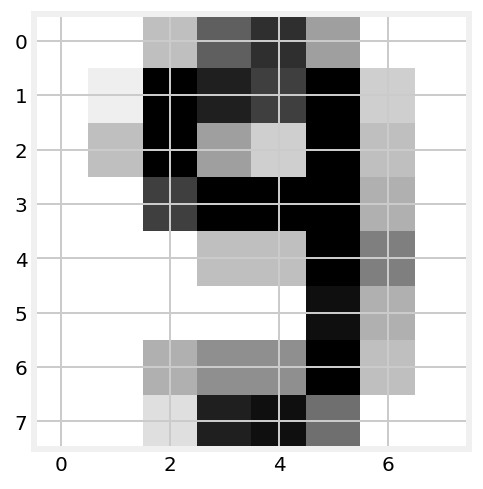

In [5]:
# the number 9
plt.imshow(digits.images[-5], cmap=plt.cm.gray_r, interpolation='nearest')

In [6]:
digits_X, digits_y = digits.data, digits.target

In [7]:
digits_X.shape

(1797, 64)

### 2. Cross-validate a logistic regression on the data.

In [8]:
# What if we just use logistic regression without doing anything?
logistic = LogisticRegression()
cross_val_score(logistic, digits_X, digits_y, cv=5, scoring='accuracy').mean()
# OK not bad!!!

0.9210188113360701

### 3. Use PCA to transform the digits data

Let's keep all 64 components for now so that we can investigate the convergence of explained varaince.

In [9]:
pca = PCA(n_components=64)

digits_Z = pca.fit_transform(digits_X)

That was easy...

### 4. Look at the explained variance

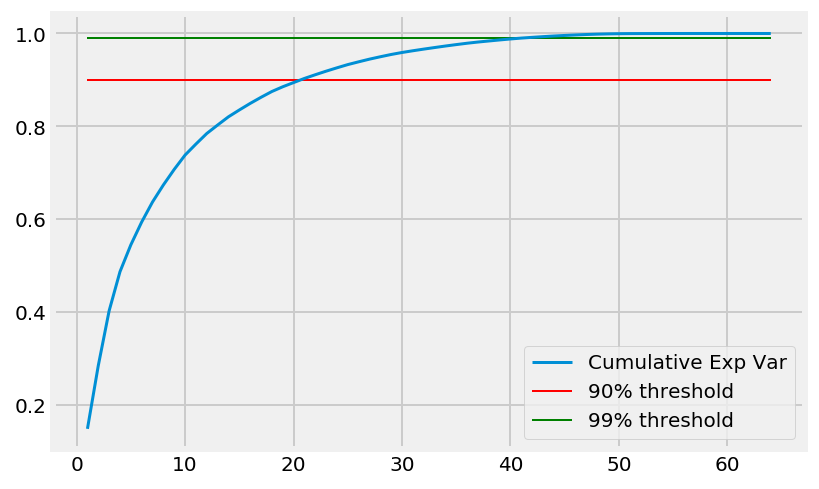

In [10]:
# Component labels
components = [i+1 for i in range(digits_Z.shape[1])]

# Cumulatively-summed explained variance ratio
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot with 90% and 99% markers
plt.plot(components, cumulative_explained_variance, lw=1.5, label='Cumulative Exp Var')
plt.hlines(0.9, 1, 64, colors='red', lw=1, label='90% threshold')
plt.hlines(0.99, 1, 64, colors='green', lw=1, label='99% threshold')
plt.legend()

It looks like 90% of the variance is explained by the time we get to about component 20, while 99% is explained by the time we get around 40.  Let's try to dial those numbers in.

In [11]:
exp_var_s = pd.Series(cumulative_explained_variance, index=components)
exp_var_s[15:25]

16    0.849402
17    0.862588
18    0.875070
19    0.885247
20    0.894303
21    0.903199
22    0.911170
23    0.918845
24    0.926074
25    0.933033
dtype: float64

In [12]:
exp_var_s[35:45]

36    0.979022
37    0.981588
38    0.983866
39    0.986088
40    0.988203
41    0.990102
42    0.991688
43    0.993200
44    0.994606
45    0.995772
dtype: float64

- \>90% variance explained in the top 21 components.
- \>99% variance explained in the top 41 components.

### 5. Revisit logistic regression with reduced dimensionality

In [13]:
digits_Z_21 = digits_Z[:,0:21]
digits_Z_41 = digits_Z[:,0:41]

In [14]:
logistic = LogisticRegression()

lr64_score = cross_val_score(logistic, digits_X, digits_y, cv=5, scoring='accuracy').mean()
lr41_score = cross_val_score(logistic, digits_Z_41, digits_y, cv=5, scoring='accuracy').mean()
lr21_score = cross_val_score(logistic, digits_Z_21, digits_y, cv=5, scoring='accuracy').mean()
print('64 components --> mean accuracy = ', lr64_score)
print('41 components --> mean accuracy = ', lr41_score)
print('21 components --> mean accuracy = ', lr21_score)

64 components --> mean accuracy =  0.9210188113360701
41 components --> mean accuracy =  0.9193229696457932
21 components --> mean accuracy =  0.9186919212552007


In [15]:
0.9210188113360701-0.9186919212552007

0.0023268900808693926

So dropping 42 dimensions dropped accuracy by only 0.23%!

### 6. Just for fun...

We can actually reconstitute the reduced images through an inverse transform that is stored in the PCA object.  This will indicate what is beeing "seen" in our reduced data.  The inverse transform maps our 21-dimensional image data back to 64 dimensions so that we can see it as an 8x8 image.

In [16]:
# Make a new PCA object specifically for going from 64 down to 21 dimensions.
# This is needed to get the inverse transform right.

pca = PCA(n_components=21)

digits_Z_21 = pca.fit_transform(digits_X)

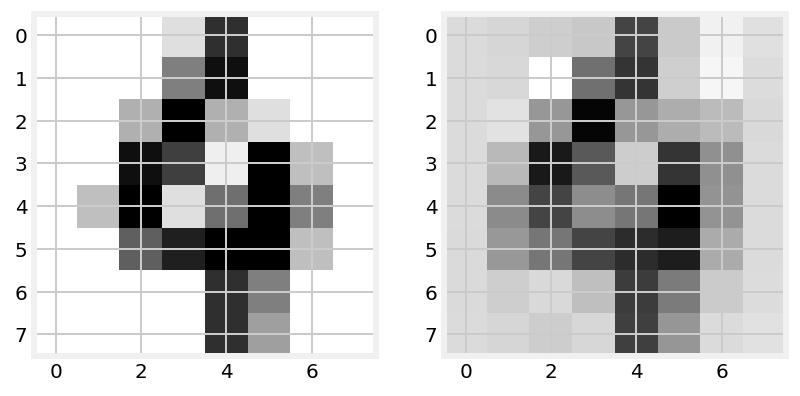

In [17]:
# Pick a row, any row...
row = 100  # <-- choose the row you want to look at

#pca.inverse_transform
plt.subplot(121)
plt.imshow(digits.images[row], cmap=plt.cm.gray_r, interpolation='nearest')

plt.subplot(122)
im_data = pca.inverse_transform(digits_Z_21[row,:])
im_data = im_data.reshape(8,8)
plt.imshow(im_data, cmap=plt.cm.gray_r, interpolation='nearest')

So it's a little fuzzier, a little less sharply contrasted, but hey, it works!